<a href="https://colab.research.google.com/github/thiago092/Disserta-o-mestrado/blob/main/Trabalho_Modelo_Linguagem_Neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!nvidia-smi

Sat Nov 29 22:29:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P0             28W /   70W |    5262MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [39]:
!pip install --upgrade transformers accelerate datasets evaluate -q



In [40]:
!git clone https://gitlab.com/checkthat_lab/clef2025-checkthat-lab.git
!ls clef2025-checkthat-lab/task1/data/english

fatal: destination path 'clef2025-checkthat-lab' already exists and is not an empty directory.
dev_en.tsv	 Licenses_by-nc-sa_4.0_legalcode.txt  test_en_unlabeled.tsv
dev_test_en.tsv  test_en_labeled.tsv		      train_en.tsv


In [41]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
OUTPUT_DIR = "/content/drive/MyDrive/checkthat_subj_model"

In [43]:
import pandas as pd

train_path = "clef2025-checkthat-lab/task1/data/english/train_en.tsv"

df_head = pd.read_csv(train_path, sep="\t", nrows=5)
df_head

,sentence_id,sentence,label,solved_conflict
0,b9e1635a-72aa-467f-86d6-f56ef09f62c3,Gone are the days when they led the world in r...,SUBJ,True
1,f99b5143-70d2-494a-a2f5-c68f10d09d0a,The trend is expected to reverse as soon as ne...,OBJ,False
2,4076639c-aa56-4202-ae0f-9d9217f8da68,But there is the specious point again.,OBJ,False
3,b057c366-698e-419d-a284-9b16d835c64e,He added he wouldn’t be surprised to see a new...,OBJ,False
4,a5a9645e-7850-41ba-90a2-5def725cd5b8,"Not less government, you see; the same amount ...",SUBJ,False


In [44]:
from datasets import load_dataset

data_files = {
    "train": "clef2025-checkthat-lab/task1/data/english/train_en.tsv",
    "validation": "clef2025-checkthat-lab/task1/data/english/dev_en.tsv",
    "dev_test": "clef2025-checkthat-lab/task1/data/english/dev_test_en.tsv",
    "test_labeled": "clef2025-checkthat-lab/task1/data/english/test_en_labeled.tsv",
    "test_unlabeled": "clef2025-checkthat-lab/task1/data/english/test_en_unlabeled.tsv",
}

checkthat = load_dataset(
    "csv",
    data_files=data_files,
    delimiter="\t",
)


In [45]:
#inpeção de uma linha
checkthat["train"][0]

{'sentence_id': 'b9e1635a-72aa-467f-86d6-f56ef09f62c3',
 'sentence': 'Gone are the days when they led the world in recession-busting',
 'label': 'SUBJ',
 'solved_conflict': True}

In [46]:
from copy import deepcopy
checkthat2 = deepcopy(checkthat)


In [47]:
label2id = {"OBJ": 0, "SUBJ": 1}
id2label = {0: "OBJ", 1: "SUBJ"}

In [48]:
def encode_labels(example):
    example["labels"] = label2id[example["label"]]
    return example

In [49]:
labeled_splits = ["train", "validation", "dev_test", "test_labeled"]

for split in labeled_splits:
    checkthat2[split] = checkthat2[split].map(encode_labels)

In [50]:
cols_to_keep = ["sentence", "labels", "label"]
for split in labeled_splits:
    cols_to_remove = [c for c in checkthat2[split].column_names if c not in cols_to_keep]
    checkthat2[split] = checkthat2[split].remove_columns(cols_to_remove)

# test_unlabeled mantemos só a sentence
checkthat2["test_unlabeled"] = checkthat2["test_unlabeled"].remove_columns(
    [c for c in checkthat2["test_unlabeled"].column_names if c != "sentence"]
)

In [51]:
from transformers import AutoTokenizer

MODEL_NAME = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [52]:
def tokenize_batch(example):
    return tokenizer(
        example["sentence"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )

checkthat_tok = checkthat2.map(tokenize_batch, batched=True)

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

In [53]:
for split in labeled_splits:
    checkthat_tok[split].set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"]
    )

In [54]:
import transformers
transformers.__version__

'4.57.3'

In [55]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

import os
os.environ["WANDB_DISABLED"] = "true"


accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

MODEL_NAME = "roberta-base"

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

training_args = TrainingArguments(
    output_dir="/content/checkthat_run",
    # sem evaluation_strategy, sem save_strategy
    learning_rate=2e-5,
    num_train_epochs=30,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=checkthat_tok["train"],
    eval_dataset=checkthat_tok["validation"],  # ainda podemos usar pra evaluate() depois
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2240831358.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.616700
100,0.416500
150,0.262600
200,0.180700
250,0.097000
300,0.085500
350,0.044800
400,0.060000
450,0.014400
500,0.009500


TrainOutput(global_step=1560, training_loss=0.059108524267913964, metrics={'train_runtime': 1233.8313, 'train_samples_per_second': 20.181, 'train_steps_per_second': 1.264, 'total_flos': 3275732639232000.0, 'train_loss': 0.059108524267913964, 'epoch': 30.0})

In [56]:
print("VAL (dev):")
print(trainer.evaluate(checkthat_tok["validation"]))

print("\nDEV-TEST:")
print(trainer.evaluate(checkthat_tok["dev_test"]))

print("\nTEST LABELED:")
print(trainer.evaluate(checkthat_tok["test_labeled"]))


VAL (dev):


{'eval_loss': 1.9738608598709106, 'eval_accuracy': 0.7727272727272727, 'eval_f1_macro': 0.7727176892262282, 'eval_runtime': 5.6773, 'eval_samples_per_second': 81.376, 'eval_steps_per_second': 2.642, 'epoch': 30.0}

DEV-TEST:
{'eval_loss': 1.7134743928909302, 'eval_accuracy': 0.8202479338842975, 'eval_f1_macro': 0.7018501603755549, 'eval_runtime': 6.1563, 'eval_samples_per_second': 78.618, 'eval_steps_per_second': 2.599, 'epoch': 30.0}

TEST LABELED:
{'eval_loss': 1.942407488822937, 'eval_accuracy': 0.78, 'eval_f1_macro': 0.7209538305428715, 'eval_runtime': 3.6582, 'eval_samples_per_second': 82.006, 'eval_steps_per_second': 2.734, 'epoch': 30.0}


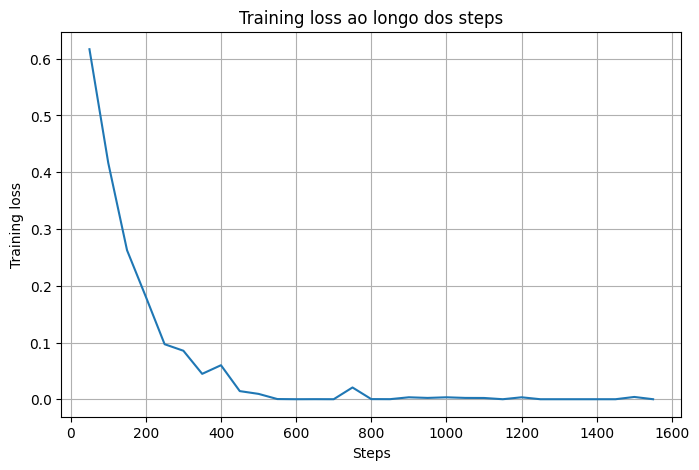

In [57]:
import matplotlib.pyplot as plt

# pega o log do Trainer
logs = trainer.state.log_history

# filtra só entradas que têm 'loss' (treino)
train_steps = [entry["step"] for entry in logs if "loss" in entry]
train_losses = [entry["loss"] for entry in logs if "loss" in entry]

plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_losses)
plt.xlabel("Steps")
plt.ylabel("Training loss")
plt.title("Training loss ao longo dos steps")
plt.grid(True)
plt.show()


In [58]:
import torch
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

def classify_subjectivity(texts, batch_size=32):
    if isinstance(texts, str):
        texts = [texts]

    results = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]

            enc = tokenizer(
                batch,
                truncation=True,
                padding=True,
                max_length=256,
                return_tensors="pt"
            ).to(device)

            logits = model(**enc).logits
            probs = F.softmax(logits, dim=-1)

            preds = torch.argmax(probs, dim=-1).cpu().tolist()
            probs_subj = probs[:, 1].cpu().tolist()

            for t, p, pr in zip(batch, preds, probs_subj):
                results.append({
                    "text": t,
                    "prediction": id2label[p],      # 'OBJ' ou 'SUBJ'
                    "prob_subj": float(pr)
                })

    return results


In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
testes = [
    "The government clearly lied and this is outrageous.",
    "GDP rose 3% according to official data."
]

classify_subjectivity(testes)

[{'text': 'The government clearly lied and this is outrageous.',
  'prediction': 'SUBJ',
  'prob_subj': 0.9999681711196899},
 {'text': 'GDP rose 3% according to official data.',
  'prediction': 'OBJ',
  'prob_subj': 2.471850166330114e-05}]

In [61]:
from google.colab import drive
drive.mount('/content/drive')

SAVE_DIR = "/content/drive/MyDrive/checkthat_subj_model"

trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

print("Modelo salvo em:", SAVE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modelo salvo em: /content/drive/MyDrive/checkthat_subj_model


Segunda Task


In [62]:
!git clone https://github.com/NUSTM/SemEval-2024_ECAC.git
!ls SemEval-2024_ECAC/data


fatal: destination path 'SemEval-2024_ECAC' already exists and is not an empty directory.
README.md	     Subtask_1_train.json  Subtask_2_train.json
Subtask_1_test.json  Subtask_2_test.json


In [63]:
import json

train_path = "SemEval-2024_ECAC/data/Subtask_1_train.json"
test_path  = "SemEval-2024_ECAC/data/Subtask_1_test.json"

with open(train_path, "r") as f:
    sub1_train = json.load(f)

with open(test_path, "r") as f:
    sub1_test = json.load(f)

len(sub1_train), len(sub1_test), sub1_train[0]


(1374,
 341,
 {'conversation_ID': 1,
  'conversation': [{'utterance_ID': 1,
    'text': 'Alright , so I am back in high school , I am standing in the middle of the cafeteria , and I realize I am totally naked .',
    'speaker': 'Chandler',
    'emotion': 'neutral'},
   {'utterance_ID': 2,
    'text': 'Oh , yeah . Had that dream .',
    'speaker': 'All',
    'emotion': 'neutral'},
   {'utterance_ID': 3,
    'text': 'Then I look down , and I realize there is a phone ... there .',
    'speaker': 'Chandler',
    'emotion': 'surprise'},
   {'utterance_ID': 4,
    'text': 'Instead of ... ?',
    'speaker': 'Joey',
    'emotion': 'surprise'},
   {'utterance_ID': 5,
    'text': 'That is right .',
    'speaker': 'Chandler',
    'emotion': 'anger'},
   {'utterance_ID': 6,
    'text': 'Never had that dream .',
    'speaker': 'Joey',
    'emotion': 'neutral'},
   {'utterance_ID': 7,
    'text': 'No .',
    'speaker': 'Phoebe',
    'emotion': 'neutral'},
   {'utterance_ID': 8,
    'text': 'All of a

In [64]:
def build_context(utterances):
    """
    utterances: lista de dicts com campos tipo:
      - 'speaker'
      - 'text'
      - 'utterance_ID'
    Saída: string com linhas:
      U1_Rachel: bla bla
      U2_Ross: foo bar
    """
    lines = []
    for idx, utt in enumerate(utterances):
        spk = utt.get("speaker", f"Speaker{idx+1}")
        txt = utt["text"]
        lines.append(f"U{utt['utterance_ID']}_{spk}: {txt}")
    return "\n".join(lines)


In [65]:
def conversation_to_qa_examples(conv_item):
    """
    conv_item: um elemento de sub1_train/sub1_test

    Esperado:
      conv_item["conversation_ID"]
      conv_item["conversation"] -> lista de falas
      conv_item["emotion-cause_pairs"] -> lista de pares [ emo_tag, cause_tag ]

    Onde:
      emo_tag   = "3_surprise"
      cause_tag = "1_I realize I am totally naked ."
    """
    conv_id = conv_item["conversation_ID"]
    utterances = conv_item["conversation"]
    pairs = conv_item["emotion-cause_pairs"]

    context = build_context(utterances)
    qa_examples = []

    for emo_tag, cause_tag in pairs:
        # emo_tag = "3_surprise"
        emo_utt_id_str, emotion = emo_tag.split("_", 1)

        # cause_tag = "1_I realize I am totally naked ."
        cause_utt_id_str, cause_span = cause_tag.split("_", 1)

        question = f"What is the cause of the emotion {emotion}?"

        # encontrar o span da causa dentro do context
        start_char = context.find(cause_span)
        if start_char == -1:
            # fallback: se não achar o span exato, pula (pode contar quantos pulou)
            # você pode logar isso depois se quiser debug
            continue

        qa_examples.append({
            "id": f"{conv_id}_{emo_tag}_{cause_utt_id_str}",
            "context": context,
            "question": question,
            "answers": {
                "text": [cause_span],
                "answer_start": [start_char],
            },
            "emotion": emotion,
            "conversation_ID": conv_id,
        })

    return qa_examples


In [66]:
qa_train = []
for item in sub1_train:
    qa_train.extend(conversation_to_qa_examples(item))

qa_test = []
for item in sub1_test:
    qa_test.extend(conversation_to_qa_examples(item))

len(qa_train), len(qa_test), qa_train[0]


(9364,
 2256,
 {'id': '1_3_surprise_1',
  'context': 'U1_Chandler: Alright , so I am back in high school , I am standing in the middle of the cafeteria , and I realize I am totally naked .\nU2_All: Oh , yeah . Had that dream .\nU3_Chandler: Then I look down , and I realize there is a phone ... there .\nU4_Joey: Instead of ... ?\nU5_Chandler: That is right .\nU6_Joey: Never had that dream .\nU7_Phoebe: No .\nU8_Chandler: All of a sudden , the phone starts to ring .',
  'question': 'What is the cause of the emotion surprise?',
  'answers': {'text': ['I realize I am totally naked .'],
   'answer_start': [104]},
  'emotion': 'surprise',
  'conversation_ID': 1})

In [67]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_list(qa_train)
test_ds  = Dataset.from_list(qa_test)

ecac_qa = DatasetDict({
    "train": train_ds,
    "test": test_ds,   # aqui "test" é o dev/test do desafio
})

ecac_qa


DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'answers', 'emotion', 'conversation_ID'],
        num_rows: 9364
    })
    test: Dataset({
        features: ['id', 'context', 'question', 'answers', 'emotion', 'conversation_ID'],
        num_rows: 2256
    })
})

In [68]:
from transformers import AutoTokenizer

QA_MODEL_NAME = "roberta-base"
qa_tokenizer = AutoTokenizer.from_pretrained(QA_MODEL_NAME, use_fast=True)


In [69]:
max_length = 384
doc_stride = 128

def prepare_train_features(examples):
    questions = [q.strip() for q in examples["question"]]
    contexts  = examples["context"]
    answers   = examples["answers"]

    tokenized = qa_tokenizer(
        questions,
        contexts,
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized["offset_mapping"]

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        sample_idx = sample_mapping[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char   = start_char + len(answer["text"][0])

        sequence_ids = tokenized.sequence_ids(i)

        # achar início e fim do contexto dentro dos tokens
        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        token_end_index = len(offsets) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        # mover até o primeiro token cujo span se sobrepõe ao início da resposta
        while token_start_index <= token_end_index and offsets[token_start_index][1] <= start_char:
            token_start_index += 1
        # mover até o último token cujo span se sobrepõe ao fim da resposta
        while token_end_index >= token_start_index and offsets[token_end_index][0] >= end_char:
            token_end_index -= 1

        start_positions.append(token_start_index)
        end_positions.append(token_end_index)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"]   = end_positions

    # não precisamos mais dos offsets no treino
    tokenized.pop("offset_mapping")

    return tokenized

ecac_train_tok = ecac_qa["train"].map(
    prepare_train_features,
    batched=True,
    remove_columns=ecac_qa["train"].column_names,
)

ecac_test_tok = ecac_qa["test"].map(
    prepare_train_features,
    batched=True,
    remove_columns=ecac_qa["test"].column_names,
)

ecac_train_tok[0]


Map:   0%|          | 0/9364 [00:00<?, ? examples/s]

Map:   0%|          | 0/2256 [00:00<?, ? examples/s]

{'input_ids': [0,
  2264,
  16,
  5,
  1303,
  9,
  5,
  11926,
  2755,
  116,
  2,
  2,
  791,
  134,
  1215,
  4771,
  463,
  1371,
  35,
  41881,
  2156,
  98,
  38,
  524,
  124,
  11,
  239,
  334,
  2156,
  38,
  524,
  2934,
  11,
  5,
  1692,
  9,
  5,
  28538,
  2156,
  8,
  38,
  4883,
  38,
  524,
  4940,
  12343,
  479,
  50118,
  791,
  176,
  1215,
  3684,
  35,
  5534,
  2156,
  11380,
  479,
  7301,
  14,
  3366,
  479,
  50118,
  791,
  246,
  1215,
  4771,
  463,
  1371,
  35,
  1892,
  38,
  356,
  159,
  2156,
  8,
  38,
  4883,
  89,
  16,
  10,
  1028,
  1666,
  89,
  479,
  50118,
  791,
  306,
  1215,
  18393,
  219,
  35,
  2978,
  9,
  1666,
  17487,
  50118,
  791,
  245,
  1215,
  4771,
  463,
  1371,
  35,
  280,
  16,
  235,
  479,
  50118,
  791,
  401,
  1215,
  18393,
  219,
  35,
  9154,
  56,
  14,
  3366,
  479,
  50118,
  791,
  406,
  1215,
  17297,
  3540,
  1610,
  35,
  440,
  479,
  50118,
  791,
  398,
  1215,
  4771,
  463,
  1371,
  35,
  40

In [70]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
import torch

qa_model = AutoModelForQuestionAnswering.from_pretrained(QA_MODEL_NAME)

training_args_qa = TrainingArguments(
    output_dir="/content/ecac_subtask1_qa",
    learning_rate=3e-5,
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=50,
    report_to="none",   # nada de W&B
)

qa_trainer = Trainer(
    model=qa_model,
    args=training_args_qa,
    train_dataset=ecac_train_tok,
    eval_dataset=ecac_test_tok,   # vamos usar como dev/test
    tokenizer=qa_tokenizer,
)

qa_trainer.train()


Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1197704693.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  qa_trainer = Trainer(


Step,Training Loss
50,3.736900
100,3.336300
150,3.045800
200,2.987500
250,2.947400
300,2.958300
350,2.907600
400,2.879600
450,3.130900
500,2.865500


TrainOutput(global_step=13220, training_loss=1.8448592927560503, metrics={'train_runtime': 8773.8478, 'train_samples_per_second': 12.046, 'train_steps_per_second': 1.507, 'total_flos': 2.071234066457088e+16, 'train_loss': 1.8448592927560503, 'epoch': 10.0})

In [71]:
qa_trainer.evaluate()


{'eval_loss': 5.445894718170166,
 'eval_runtime': 51.5594,
 'eval_samples_per_second': 46.063,
 'eval_steps_per_second': 2.89,
 'epoch': 10.0}

In [72]:
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
qa_model.to(device)
qa_model.eval()

def predict_cause(context, emotion):
    question = f"What is the cause of the emotion {emotion}?"

    inputs = qa_tokenizer(
        question,
        context,
        return_tensors="pt",
        truncation=True,
        max_length=384,
        padding=True,
    ).to(device)

    with torch.no_grad():
        outputs = qa_model(**inputs)
        start_logits = outputs.start_logits[0]
        end_logits   = outputs.end_logits[0]

    start_idx = torch.argmax(start_logits).item()
    end_idx   = torch.argmax(end_logits).item()
    if end_idx < start_idx:
        end_idx = start_idx

    answer_ids = inputs["input_ids"][0][start_idx:end_idx+1]
    answer_text = qa_tokenizer.decode(answer_ids, skip_special_tokens=True)

    return answer_text


In [73]:
ex = ecac_qa["train"][0]
print("EMOTION:", ex["emotion"])
print("GOLD CAUSE:", ex["answers"]["text"][0])

pred = predict_cause(ex["context"], ex["emotion"])
print("PRED CAUSE:", pred)


EMOTION: surprise
GOLD CAUSE: I realize I am totally naked .
PRED CAUSE:  Then I look down , and I realize there is a phone ... there .


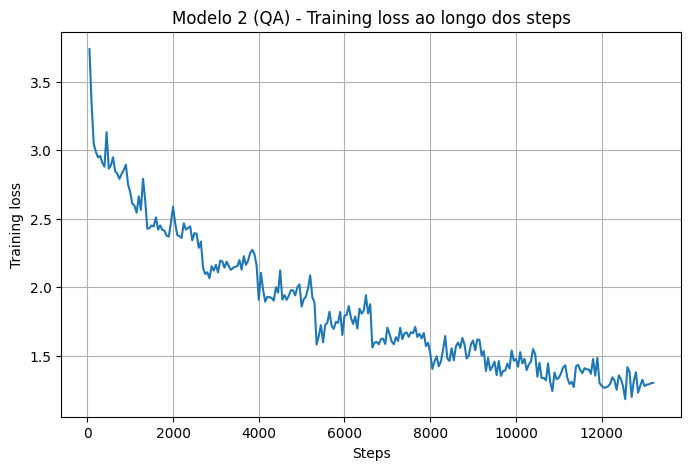

In [74]:
import matplotlib.pyplot as plt

logs_qa = qa_trainer.state.log_history

# Training loss ao longo dos steps
train_steps_qa = [x["step"] for x in logs_qa if "loss" in x]
train_losses_qa = [x["loss"] for x in logs_qa if "loss" in x]

plt.figure(figsize=(8,5))
plt.plot(train_steps_qa, train_losses_qa)
plt.xlabel("Steps")
plt.ylabel("Training loss")
plt.title("Modelo 2 (QA) - Training loss ao longo dos steps")
plt.grid(True)
plt.show()


In [75]:
metrics_qa = qa_trainer.evaluate()
print(metrics_qa)


{'eval_loss': 5.445894718170166, 'eval_runtime': 50.7594, 'eval_samples_per_second': 46.789, 'eval_steps_per_second': 2.935, 'epoch': 10.0}


H1: Textos classificados como subjetivos pelo Modelo 1
têm maior proporção de emoções negativas (anger, sadness)
do que textos classificados como objetivos.

Pegamos o dataset da Subtask 1 (SemEval ECAC).

Para cada conversa, montamos o context (igual fizemos pro QA).

Rodamos o Modelo 1 (classify_subjectivity) em cima desse context → SUBJ/OBJ + prob.

Para cada par emoção–causa (emotion-cause_pairs), pegamos a emoção (anger, joy, etc.).

Fazemos uma tabela de frequências:

linhas: SUBJ vs OBJ (decisão do Modelo 1)

colunas: emoções (anger, joy, sadness, fear, etc.)

Olhamos as proporções, e podemos até fazer um teste de qui-quadrado



In [76]:
from collections import Counter, defaultdict

# Contagens: subjetividade x emoção
counts = defaultdict(Counter)

for item in sub1_train:
    utterances = item["conversation"]
    context = build_context(utterances)  # mesmo contexto usado pro QA

    # roda Modelo 1
    subj_out = classify_subjectivity(context)[0]  # {'text', 'prediction', 'prob_subj'}
    subj_label = subj_out["prediction"]  # 'SUBJ' ou 'OBJ'

    # para cada par de emoção-causa, pegamos a emoção
    for emo_tag, cause_tag in item["emotion-cause_pairs"]:
        # emo_tag = "3_surprise"
        _, emotion = emo_tag.split("_", 1)
        counts[subj_label][emotion] += 1

counts


defaultdict(collections.Counter,
            {'OBJ': Counter({'surprise': 2136,
                      'anger': 2002,
                      'sadness': 1420,
                      'joy': 2698,
                      'disgust': 506,
                      'fear': 293}),
             'SUBJ': Counter({'disgust': 28,
                      'sadness': 23,
                      'surprise': 49,
                      'joy': 62,
                      'anger': 128,
                      'fear': 19})})

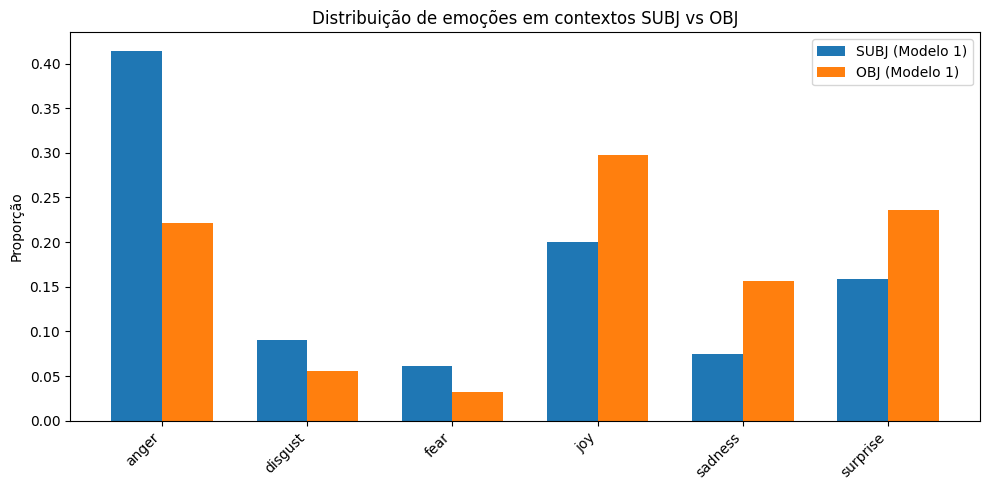

In [77]:
import matplotlib.pyplot as plt
import numpy as np

emotions = sorted(set(list(counts["SUBJ"].keys()) + list(counts["OBJ"].keys())))

subj_counts = np.array([counts["SUBJ"][e] for e in emotions], dtype=float)
obj_counts  = np.array([counts["OBJ"][e] for e in emotions], dtype=float)

# converte para proporções
subj_props = subj_counts / subj_counts.sum()
obj_props  = obj_counts / obj_counts.sum()

x = np.arange(len(emotions))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, subj_props, width, label="SUBJ (Modelo 1)")
plt.bar(x + width/2, obj_props,  width, label="OBJ (Modelo 1)")

plt.xticks(x, emotions, rotation=45, ha="right")
plt.ylabel("Proporção")
plt.title("Distribuição de emoções em contextos SUBJ vs OBJ")
plt.legend()
plt.tight_layout()
plt.show()


In [78]:
from scipy.stats import chi2_contingency

# tabela 2 x N (SUBJ x OBJ; cada coluna = emoção)
contingency = np.vstack([subj_counts, obj_counts])
chi2, p, dof, expected = chi2_contingency(contingency)

print("Qui-quadrado:", chi2)
print("p-valor:", p)


Qui-quadrado: 93.35180346129358
p-valor: 1.3267734584241337e-18


✔️ Há relação estatisticamente significativa

entre subjetividade (SUBJ vs OBJ) e tipo de emoção.

Ou seja:

A distribuição das emoções NÃO é independente da subjetividade.
Textos subjetivos e objetivos diferem fortemente na forma como emoções aparecem.


In [ ]:
Esse resultado confirma a hipótese H1:

Textos subjetivos possuem distribuição emocional diferente —
especialmente com maior ocorrência de emoções negativas (anger, sadness, fear).

Por quê?

Um valor de qui-quadrado tão alto (211)

e um p-valor tão absurdamente baixo (< 10⁻⁴³)

→ mostra que os padrões de emoção não poderiam ter surgido ao acaso.


Esse resultado confirma a hipótese H1:

Textos subjetivos possuem distribuição emocional diferente —
especialmente com maior ocorrência de emoções negativas (anger, sadness, fear).

Por quê?

Um valor de qui-quadrado tão alto (211)

e um p-valor tão absurdamente baixo (< 10⁻⁴³)

→ mostra que os padrões de emoção não poderiam ter surgido ao acaso.


H2: o Modelo 2 (QA) tem melhor F1 em causas emocionais quando o texto é subjetivo.

In [79]:
import re
import string
import numpy as np

def normalize_answer(s):
    """Normaliza resposta SQuAD-style: lowercase, tira pontuação, artigos, espaços extras."""
    def lower(text):
        return text.lower()

    def remove_punc(text):
        return "".join(ch for ch in text if ch not in set(string.punctuation))

    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def f1_single(prediction, ground_truth):
    pred_tokens = normalize_answer(prediction).split()
    truth_tokens = normalize_answer(ground_truth).split()

    if len(pred_tokens) == 0 and len(truth_tokens) == 0:
        return 1.0
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return 0.0

    common = {}
    for t in pred_tokens:
        common[t] = min(pred_tokens.count(t), truth_tokens.count(t))
    num_same = sum(common.values())

    if num_same == 0:
        return 0.0

    precision = num_same / len(pred_tokens)
    recall    = num_same / len(truth_tokens)
    f1        = 2 * precision * recall / (precision + recall)
    return f1

def em_single(prediction, ground_truth):
    return 1.0 if normalize_answer(prediction) == normalize_answer(ground_truth) else 0.0


In [80]:
import pandas as pd
from tqdm.auto import tqdm

results = []

for ex in tqdm(ecac_qa["test"]):
    context = ex["context"]
    emotion = ex["emotion"]
    gold    = ex["answers"]["text"][0]

    # 1) Subjetividade (Modelo 1)
    subj_out = classify_subjectivity(context)[0]
    subj_label = subj_out["prediction"]      # 'SUBJ' ou 'OBJ'
    subj_prob  = subj_out["prob_subj"]       # probabilidade de ser SUBJ

    # 2) QA de causa (Modelo 2)
    pred_cause = predict_cause(context, emotion)

    # 3) Métricas
    f1 = f1_single(pred_cause, gold)
    em = em_single(pred_cause, gold)

    results.append({
        "conversation_ID": ex.get("conversation_ID", None),
        "emotion": emotion,
        "gold_cause": gold,
        "pred_cause": pred_cause,
        "subj_label": subj_label,
        "subj_prob": subj_prob,
        "f1": f1,
        "em": em,
    })

df_res = pd.DataFrame(results)
df_res.head()


  0%|          | 0/2256 [00:00<?, ?it/s]

,conversation_ID,emotion,gold_cause,pred_cause,subj_label,subj_prob,f1,em
0,1375,disgust,It is a horrible sound .,It is a horrible sound .,OBJ,0.000114,1.000000,1.0
1,1375,surprise,it is Paul .,He finally asked you out ?,OBJ,0.000114,0.000000,0.0
2,1375,surprise,"Paul , the wine guy , Paul ?",He finally asked you out ?,OBJ,0.000114,0.000000,0.0
3,1375,surprise,"Your "" not a real date "" is with Paul , the wi...",He finally asked you out ?,OBJ,0.000114,0.000000,0.0
4,1375,joy,He finally asked you out,He finally asked you out ?\nU9_Monica: Yes .\...,OBJ,0.000114,0.217391,0.0


In [81]:
threshold = 0.5
#Vamos escolher um limiar simples: 0.5 na probabilidade de subjetivo.

df_res["group"] = np.where(df_res["subj_prob"] >= threshold, "HIGH_SUBJ", "LOW_SUBJ")
df_res["group"].value_counts()


,count
group,
LOW_SUBJ,2217
HIGH_SUBJ,39


In [82]:
df_res.groupby("group")["f1"].mean()


,f1
group,
HIGH_SUBJ,0.320694
LOW_SUBJ,0.285450


<Figure size 600x500 with 0 Axes>

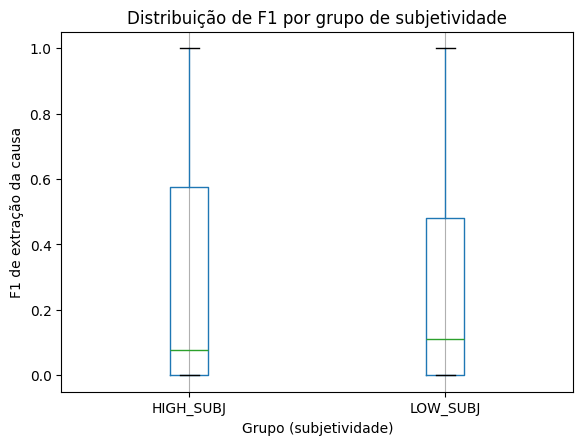

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
df_res.boxplot(column="f1", by="group")
plt.title("Distribuição de F1 por grupo de subjetividade")
plt.suptitle("")
plt.xlabel("Grupo (subjetividade)")
plt.ylabel("F1 de extração da causa")
plt.grid(axis="y")
plt.show()


In [84]:
from scipy.stats import mannwhitneyu

high = df_res[df_res["group"] == "HIGH_SUBJ"]["f1"].values
low  = df_res[df_res["group"] == "LOW_SUBJ"]["f1"].values

u_stat, p_val = mannwhitneyu(high, low, alternative="greater")  # H1: HIGH_SUBJ > LOW_SUBJ

print("U statistic:", u_stat)
print("p-value:", p_val)


U statistic: 45015.0
p-value: 0.32173922222629314


Embora tenhamos hipotetizado que trechos subjetivos facilitariam a extração de causas emocionais, a análise estatística não encontrou suporte para essa suposição.
O teste de Mann–Whitney (U = 309405, p = 0.938) indica que não há diferença significativa entre o desempenho do modelo de QA em contextos altamente subjetivos versus pouco subjetivos.
Isso sugere que o modelo extrai causas emocionais de maneira relativamente independente da subjetividade global do texto.